CNN (Gray Image)

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)


net.layer4 = nn.Identity()  # remove last residual block
net.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # keep global pooling

net.fc = nn.Linear(256, 4)

#print(net)

# Get total parameters
ps = sum(param.nelement() for param in net.parameters())
print(f"{ps:,d} parameters")

# Preprocessing
weights = torchvision.models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

imagenet_classes = torchvision.models.resnet._IMAGENET_CATEGORIES

2,783,812 parameters


Data Loader

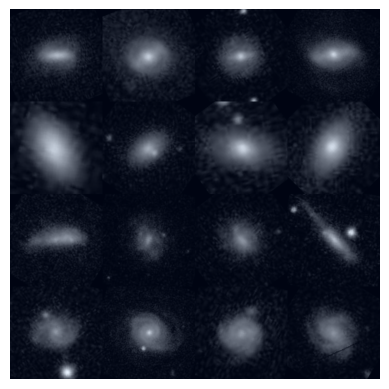

[['barred' 'barred' 'barred' 'barred']
 ['elliptical' 'elliptical' 'elliptical' 'elliptical']
 ['irregular' 'irregular' 'irregular' 'irregular']
 ['spiral' 'spiral' 'spiral' 'spiral']]
torch.Size([16, 3, 224, 224])


In [33]:
import torchvision.transforms as transforms
import numpy as np


grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # keeps shape [3,H,W]
    transforms.RandomRotation(degrees=180),
    transforms.RandomHorizontalFlip(),
    preprocess  # includes normalization for 3 channels
])

path = r'E:\machine learning\class exercises\final machine learning project - galaxies\250711-galaxies-data\galaxies\train'
train_set = torchvision.datasets.ImageFolder(path, transform=grayscale_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
testpath = r"E:\machine learning\class exercises\final machine learning project - galaxies\250711-galaxies-data\galaxies\test"
test_set = torchvision.datasets.ImageFolder(testpath, transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=2)


images_per_class = []
labels_list = []

for class_idx in range(len(train_set.classes)):
    count = 0
    for img, label in train_set:
        if label == class_idx:
            images_per_class.append(img)
            labels_list.append(train_set.classes[label])
            count += 1
        if count == 4:
            break

# Stack and make grid (no padding)
images_tensor = torch.stack(images_per_class)
grid = torchvision.utils.make_grid(images_tensor, nrow=4, padding=0, normalize=True).permute(1, 2, 0)

# Plot
plt.figure(dpi=100)
plt.axis("off")
plt.imshow(grid)
plt.show()

# Print label matrix
label_matrix = np.array(labels_list).reshape(4, 4)
print(label_matrix)
print(images_tensor.shape)

In [17]:
import torch.nn as nn
LR = 1e-4
num_classes = 4
net.fc = nn.Linear(net.fc.in_features, num_classes)
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(DEVICE)
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_fun = torch.nn.CrossEntropyLoss()

Training Loop

In [18]:
EPOCHS = 10

net.train()
steps = 0
train_losses = []
train_accuracies = []
step_indices = []
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = net(images)
        loss = loss_fun(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        predictions = logits.argmax(1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}  Accuracy: {accuracy:.2f}%")

[Epoch 1] Loss: 0.8621  Accuracy: 70.37%
[Epoch 2] Loss: 0.4233  Accuracy: 87.78%
[Epoch 3] Loss: 0.3065  Accuracy: 90.40%
[Epoch 4] Loss: 0.2569  Accuracy: 91.77%
[Epoch 5] Loss: 0.2319  Accuracy: 92.21%
[Epoch 6] Loss: 0.2089  Accuracy: 93.05%
[Epoch 7] Loss: 0.1916  Accuracy: 93.73%
[Epoch 8] Loss: 0.1719  Accuracy: 94.33%
[Epoch 9] Loss: 0.1602  Accuracy: 94.50%
[Epoch 10] Loss: 0.1559  Accuracy: 94.81%


Performance Graphs

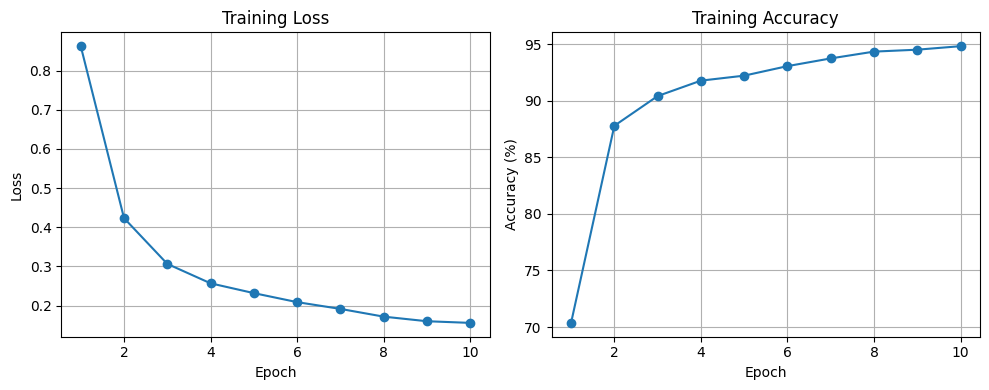

In [19]:
def plot_metrics(losses, accs, title="CNN Training Performance"):
    epochs = range(1, len(losses)+1)

    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accs, marker='o', label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, "CNN")

Evaluation with RGB

In [20]:
nclasses = len(train_set.classes)
cm = torch.zeros(nclasses, nclasses, dtype=torch.long)
net.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        logits = net(images)
    predictions = logits.argmax(1)
    counts = torch.bincount(labels * nclasses + predictions, minlength=nclasses ** 2)
    cm += counts.view(nclasses, nclasses).cpu()

accuracy = cm.diag().sum() / cm.sum()
print(f"Accuracy: {100 * accuracy:.1f}%")

Accuracy: 80.7%


Evaluation with Gray Image

In [21]:
test_set = torchvision.datasets.ImageFolder(testpath, transform=grayscale_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

nclasses = len(train_set.classes)
cm = torch.zeros(nclasses, nclasses, dtype=torch.long)
net.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        logits = net(images)
    predictions = logits.argmax(1)
    counts = torch.bincount(labels * nclasses + predictions, minlength=nclasses ** 2)
    cm += counts.view(nclasses, nclasses).cpu()

accuracy = cm.diag().sum() / cm.sum()
print(f"Accuracy: {100 * accuracy:.1f}%")

Accuracy: 95.6%


Confusion Matrix

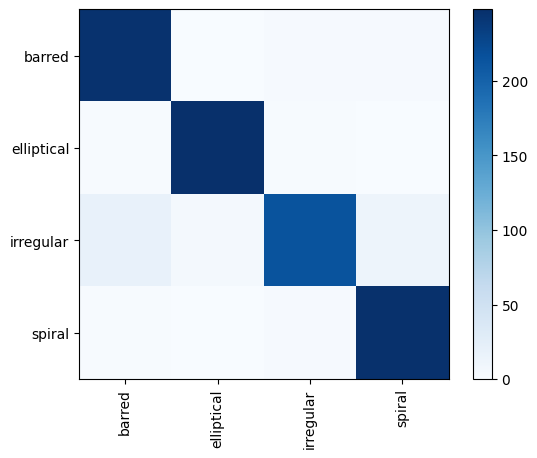

In [22]:
cmnorm = cm / cm.sum(1)

plt.figure(dpi=100)
plt.imshow(cm, cmap="Blues")
plt.xticks(range(nclasses), train_set.classes, rotation=90)
plt.yticks(range(nclasses), train_set.classes)
plt.colorbar()

Error Pattern Analysis: Most Frequent Misclassifications

In [23]:
error_matrix = cm.clone()
for i in range(nclasses):
    error_matrix[i, i] = 0  # zero out the diagonal

# Get top 5 most frequent mistakes
error_pairs = torch.nonzero(error_matrix, as_tuple=False)
error_counts = [error_matrix[i, j].item() for i, j in error_pairs]
top_errors = sorted(zip(error_counts, error_pairs.tolist()), reverse=True)[:5]

for count, (true_idx, pred_idx) in top_errors:
    print(f"Mistook {train_set.classes[true_idx]} as {train_set.classes[pred_idx]} → {count} times")

Mistook irregular as barred → 19 times
Mistook irregular as spiral → 12 times
Mistook irregular as elliptical → 4 times
Mistook spiral as irregular → 2 times
Mistook barred as spiral → 2 times


Error Analysis: Visualization of Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.98422676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.44392177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.827364].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.7925056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.8

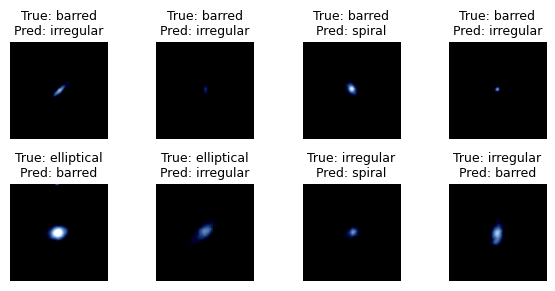

In [24]:
net.eval()
wrong_imgs = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = net(images)
        preds = logits.argmax(1)
        wrong = preds != labels
        if wrong.any():
            wrong_imgs.extend(images[wrong].cpu())
            wrong_labels.extend(labels[wrong].cpu())
            wrong_preds.extend(preds[wrong].cpu())

# Show first 8 misclassified images
plt.figure(figsize=(6, 3))
for i in range(8):
    img = wrong_imgs[i].permute(1, 2, 0)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    true_label = train_set.classes[wrong_labels[i]]
    pred_label = train_set.classes[wrong_preds[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()